# Mapillary label analysis

## Motivation

Consider the Mapillary labelled images, and especially their 0-1 encoded versions in specific `.csv` files (*cf* `../sources/data_preprocessing.py` module).

The aim of this notebook is to describe the Mapillary data in terms of street-scene object distribution: what is the frequency of appearance of each object type? How many labels appear on a typical image? What are the most frequent object association?

## Data preparation

As usual, we import the useful module. `pandas` is of course needed, as we will handle dataframes.

In [2]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

There are two datasets that include labelled version of images: *training* and *validation* datasets. Thus we recover both ones as `.csv` files.

In [3]:
train_labels = pd.read_csv("../data/training/output/labels.csv")
validation_labels = pd.read_csv("../data/validation/output/labels.csv")

Validation label indices are slightly modified so as to concatenate both dataframes in one single label dataframe.

In [4]:
validation_labels.index = validation_labels.index + 18000
labels = pd.concat([train_labels, validation_labels])
labels.sample(10).iloc[:,:10]

,old_name,new_name,old_width,width_ratio,old_height,height_ratio,label_0,label_1,label_2,label_3
8508,Lu44gD5tWb9UCqoDTxnoEw.jpg,08508.jpg,3264,0.235294,2448,0.235294,0,0,1,1
10251,MxsIsMN-bhlPsHABqdnsIg.jpg,10251.jpg,3264,0.235294,2448,0.235294,0,0,1,1
19801,qrDMpwOEuMJWMtNMO53d2w.jpg,01801.jpg,3984,0.192771,2988,0.192771,0,0,1,1
7273,inPMzwqdYWQd825Oj1c6Xg.jpg,07273.jpg,3264,0.235294,2448,0.235294,0,0,1,1
15937,2UiUlk9K-ibfoMJ5EeSA1A.jpg,15937.jpg,3984,0.192771,2988,0.192771,0,0,0,0
8715,8UtERmXtCN1VfM0Lb4PZ4A.jpg,08715.jpg,3264,0.235294,2448,0.235294,0,0,1,1
4059,dkdcp6rOL2omNU5n-K50rw.jpg,04059.jpg,4032,0.190476,3024,0.190476,0,0,1,1
18269,mAhiSV8rtHHoaOwcmiaKzg.jpg,00269.jpg,3264,0.235294,2448,0.235294,0,0,1,1
12764,20hKoGvGKHAxORWCbvq8Yw.jpg,12764.jpg,4032,0.190476,3024,0.190476,0,0,1,1
12902,JR6FYSOzGdZ2iGfdUJd8gw.jpg,12902.jpg,3264,0.235294,1836,0.313725,1,0,1,0


We drop the useless columns ("useless" in the context of the current analysis), and get the dataset which we will work on.

In [5]:
labels = labels.drop(["old_name", "new_name", "old_width", "width_ratio", "old_height", "height_ratio"], axis=1)

## Data description

### Image labels

Here we have 20000 image labels (18000 in the training set, 2000 in the validation set), each one being characterized by 66 labels. `labels(i,j)` is equal to 1 is the j-th object is on the i-th image.

In [6]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
label_0,20000.0,0.03735,0.189623,0.0,0.0,0.0,0.0,1.0
label_1,20000.0,0.01645,0.127201,0.0,0.0,0.0,0.0,1.0
label_2,20000.0,0.84160,0.365125,0.0,1.0,1.0,1.0,1.0
label_3,20000.0,0.62640,0.483771,0.0,0.0,1.0,1.0,1.0
label_4,20000.0,0.16640,0.372449,0.0,0.0,0.0,0.0,1.0
label_5,20000.0,0.20110,0.400833,0.0,0.0,0.0,0.0,1.0
label_6,20000.0,0.46575,0.498838,0.0,0.0,0.0,1.0,1.0
label_7,20000.0,0.07430,0.262265,0.0,0.0,0.0,0.0,1.0
label_8,20000.0,0.12035,0.325379,0.0,0.0,0.0,0.0,1.0
label_9,20000.0,0.44715,0.497211,0.0,0.0,0.0,1.0,1.0


### Mapillary classification

To characterize more precisely each image, we have to recover the Mapillary classification description, in a separate `.json` configuration file.

In [7]:
with open('../data/config.json') as config_file:
    config = json.load(config_file)
config.keys()

dict_keys(['mapping', 'version', 'labels', 'folder_structure'])

In [8]:
label_description = config['labels']
type(label_description)

list

Each label is described by a dictionnary that gives information about its name (encoded name, and human-readable name), the color with which it is linked on Mapillary filtered images and additional meta-information that won't be exploited here.

In [9]:
label_description[0]

{'color': [165, 42, 42],
 'evaluate': True,
 'instances': True,
 'name': 'animal--bird',
 'readable': 'Bird'}

Consider a small sample of the names show that the labels themselves can be classified : we have a *animal* category, with *bird*, a *construction* category with *pedestrian-area* an *object* category with *bench*, *street-light* or *car*. We should even consider subcategories, for example *flat* for *construction* or *vehicle* for *object*...

In [10]:
label_names = [l['name'] for l in label_description]
label_names[0:66:11]

['animal--bird',
 'construction--flat--pedestrian-area',
 'human--rider--other-rider',
 'object--bench',
 'object--street-light',
 'object--vehicle--car']

We can reformat these information as a dataframe, for a easier category handling.

In [11]:
def build_category_description(names):
    """Build a dataframe that contains Mapillary label category description,
    with three columns "category", "subcategory" (empty if there is no subcategory), "object"
    Parameter
    ---------
    names: list
    Mapillary label names under the format <category>--<subcategory(if needed)>--<object>
    """
    category_description = []
    for n in label_names:
        cur_name = n.split('--')
        if len(cur_name) == 2:
            cur_name.insert(1, '')
        category_description.append(cur_name)
    return pd.DataFrame(category_description, columns=["category", "subcategory", "object"])

As a consequence, we get a dataframe with 3 columns, as denoted in the docstring, and 66 rows, one for each Mapillary object type.

In [12]:
category_description = build_category_description(label_names)
category_description

,category,subcategory,object
0,animal,,bird
1,animal,,ground-animal
2,construction,barrier,curb
3,construction,barrier,fence
4,construction,barrier,guard-rail
5,construction,barrier,other-barrier
6,construction,barrier,wall
7,construction,flat,bike-lane
8,construction,flat,crosswalk-plain
9,construction,flat,curb-cut


This classification contains 7 categories, the following code line gives the number of subcategory for each of them.

In [13]:
label_categories = list(set(category_description.category))
category_description.groupby("category")["subcategory"].nunique() - 1

category
animal          0
construction    2
human           1
marking         0
nature          0
object          3
void            0
Name: subcategory, dtype: int64

## Mapillary object inventory

By simple `apply` calls, we can get the number of available objects per image, as well as the number of images in which each label is available.

In [14]:
image_count_per_label = labels.apply(sum, axis=0)
image_count_per_label.index = range(len(image_count_per_label))
image_count_per_label[:4]
print("The label '{}' is on {} images.".format(category_description.loc[0, "object"], image_count_per_label[0]))
label_count_per_image = labels.apply(sum, axis=1)
print("The image {} contains {} labels.".format(0, label_count_per_image[0]))

The label 'bird' is on 747 images.
The image 0 contains 21 labels.


As examples, we learn here that 747 images contains birds, according to Mapillary preprocessing. And that over the 66 inventoried objects, the first image contains 21 of them.

To generalize the point, we can detail these features and plot them as histograms.

In [15]:
print("Number of images per label:\n{}".format(np.round(image_count_per_label.describe(), 2)))

Number of images per label:
count       66.00
mean      6231.76
std       6725.46
min        131.00
25%        757.75
50%       3232.00
75%      10191.50
max      19787.00
dtype: float64


In [16]:
print("Number of labels per image:\n{}".format(np.round(label_count_per_image.describe(), 2)))

Number of labels per image:
count    20000.00
mean        20.56
std          4.30
min          3.00
25%         18.00
50%         21.00
75%         24.00
max         36.00
dtype: float64


### Number of images per label

Regarding the number of images per label, we can see that 18 objects (more than a quarter) are represented less than 1000 times. It may be a problem for the trained model to detect them, as they are rare. Others labels are well spread regarding the number of example images; although we have to note that some label are almost always present on the images. The ideal situation would have been to have each label on 50% of the images within the dataset...

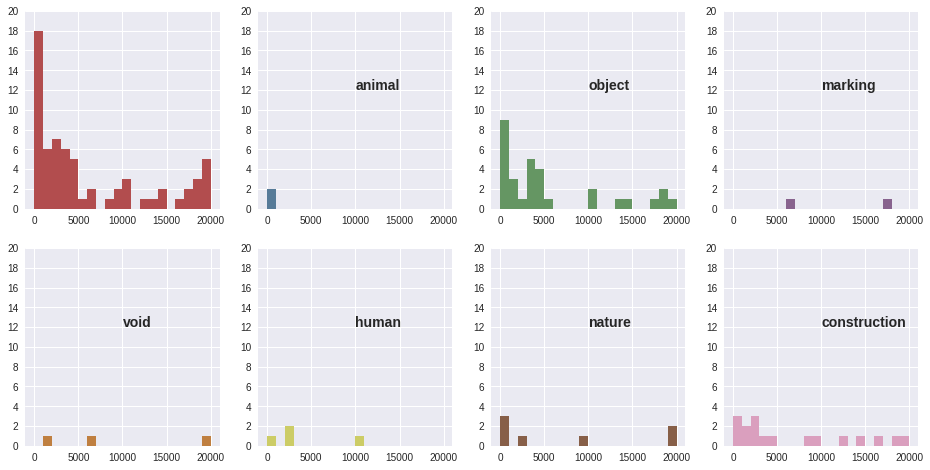

In [17]:
category_description['nb_images'] = image_count_per_label
category_description.head(10)
hist_palette = sns.color_palette("Set1", n_colors=8, desat=.5)
f, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0][0].hist(category_description.nb_images, bins=np.linspace(0, 20000, 21), color=hist_palette[0])
ax[0][0].set_yticks(np.linspace(0, 20, 11))
for i in range(category_description.category.nunique()):
    cur_cat = label_categories[i]
    data = category_description.query("category==@cur_cat").nb_images
    ax[int((i+1)/4)][(i+1)%4].hist(data, bins=np.linspace(0, 20000, 21), color=hist_palette[i+1])
    ax[int((i+1)/4)][(i+1)%4].set_yticks(np.linspace(0, 20, 11))
    ax[int((i+1)/4)][(i+1)%4].text(10000, 12, cur_cat, size=14, fontweight='bold')

By going into label detail, it is obvious for street-scene images to remark that almost every images contain a sky, a road, some cars. Considering the image segmentation process complexity, it is also quite understandable to observe a high value for unlabeled objects.

In [18]:
category_description.sort_values("nb_images", ascending=False).head(6)

,category,subcategory,object,nb_images
27,nature,,sky,19787
13,construction,flat,road,19751
45,object,support,pole,19699
65,void,,unlabeled,19548
30,nature,,vegetation,19427
55,object,vehicle,car,18708


On the other hand, rare objects within the dataset are mostly unusual vehicles like caravan, boat or trailer. It can also be unusual infrastructure like tunnels, or typical nature elements (sand) that denote a specific geographical localization.

In [19]:
category_description.sort_values("nb_images").head(6)

,category,subcategory,object,nb_images
56,object,vehicle,caravan,131
53,object,vehicle,boat,151
26,nature,,sand,179
18,construction,structure,tunnel,226
22,human,rider,other-rider,231
60,object,vehicle,trailer,232


### Number of labels per image

Considering the number of labels in single images, it seems to follow a gaussian distribution centered on 20 labels per image. By distinguishing train set and validation set images, we still observe this characteristic. It should be interesting to investigate on label associations.

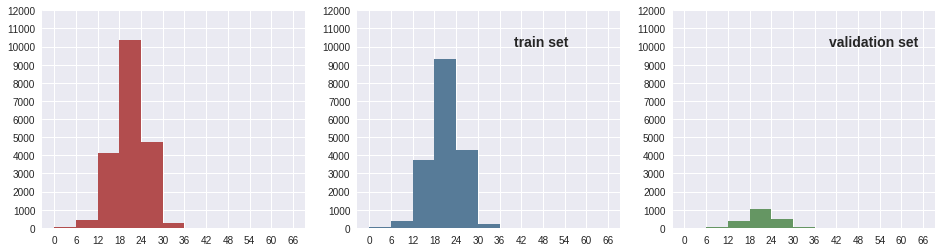

In [20]:
category_description['nb_images'] = image_count_per_label
category_description.head(10)
hist_palette = sns.color_palette("Set1", n_colors=3, desat=.5)
f, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(label_count_per_image, bins=np.linspace(0, 66, 12), color=hist_palette[0])
ax[0].set_xticks(np.linspace(0, 66, 12))
ax[0].set_yticks(np.linspace(0, 12000, 13))
ax[1].hist(label_count_per_image[:18000], bins=np.linspace(0, 66, 12), color=hist_palette[1])
ax[1].set_xticks(np.linspace(0, 66, 12))
ax[1].set_yticks(np.linspace(0, 12000, 13))
ax[1].text(40, 10000, "train set", size=14, fontweight='bold')
ax[2].hist(label_count_per_image[18000:], bins=np.linspace(0, 66, 12), color=hist_palette[2])
ax[2].set_xticks(np.linspace(0, 66, 12))
ax[2].set_yticks(np.linspace(0, 12000, 13))
ax[2].text(40, 10000, "validation set", size=14, fontweight='bold')

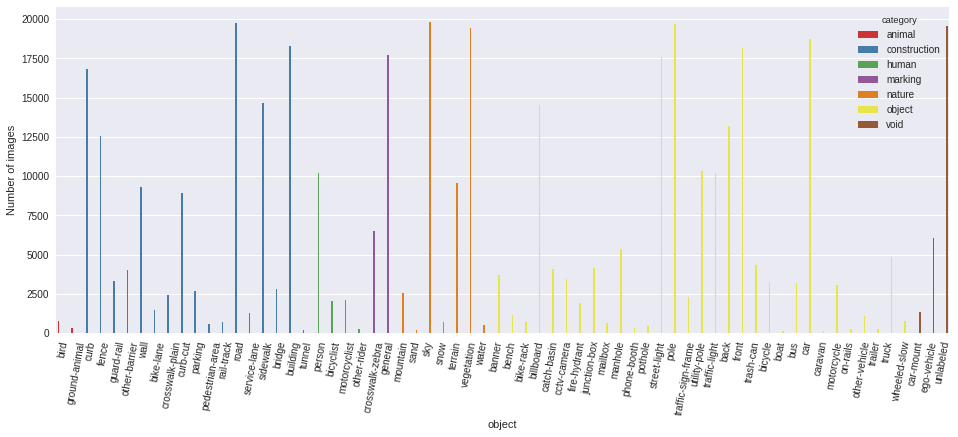

In [21]:
f = plt.figure(figsize=(16, 6))
image_per_label_plot = sns.barplot(category_description.object, category_description.nb_images, hue=category_description.category, palette="Set1")
plt.ylabel("Number of images")
plt.setp(image_per_label_plot.get_xticklabels(), rotation=80)
plt.show()

## Label association

In [22]:
import fim

In [23]:
transactions = []
for i, lab in labels.iterrows():
    transactions.append(list(itertools.compress(range(len(category_description)), lab==1)))

In [27]:
rules = fim.arules(transactions, supp=10, conf=90, report="abhCl", eval="l", thresh=1)
rules = pd.DataFrame(rules, columns=["head", "body", "item_set_support", "body_support", "head_support", "confidence", "lift"])
rules.shape

(8595353, 7)

In [28]:
rules.head(10)

,head,body,item_set_support,body_support,head_support,confidence,lift
0,45,(),19699,20000,19699,98.495000,1.000000
1,45,"(13,)",19475,19751,19699,98.602602,1.001092
2,13,"(45,)",19475,19699,19751,98.862886,1.001092
3,13,(),19751,20000,19751,98.755000,1.000000
4,45,"(27,)",19503,19787,19699,98.564714,1.000708
5,27,"(45,)",19503,19699,19787,99.005026,1.000708
6,45,"(27, 13)",19288,19548,19699,98.669941,1.001776
7,13,"(27, 45)",19288,19503,19751,98.897605,1.001444
8,27,"(13, 45)",19288,19475,19787,99.039795,1.001059
9,13,"(27,)",19548,19787,19751,98.792136,1.000376


In [29]:
category_description['nb_rules'] = [len(rules.query("head==@i")) for i in range(category_description.shape[0])]
category_description

,category,subcategory,object,nb_images,nb_rules
0,animal,,bird,747,0
1,animal,,ground-animal,329,0
2,construction,barrier,curb,16832,697944
3,construction,barrier,fence,12528,0
4,construction,barrier,guard-rail,3328,0
5,construction,barrier,other-barrier,4022,0
6,construction,barrier,wall,9315,0
7,construction,flat,bike-lane,1486,0
8,construction,flat,crosswalk-plain,2407,0
9,construction,flat,curb-cut,8943,0
